# Efficient frontier (for a portfolio of securities)

In portfolio theory (a portfolio of stocks/securities), the **efficient frontier** is a *set of optimal portfolios offering the highest expected return for a defined level of risk, or the lowest risk for a fiven level of expected return*.

In this notebook I will set about plotting the efficient frontier of a portfolio of stocks

In [2]:
# imports
import datetime
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [3]:
run_date = datetime.datetime.now().strftime("%Y-%m-%d")
run_date_dt64 = np.datetime64(run_date)

[*********************100%***********************]  3 of 3 downloaded


/Users/philip_p/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/philip_p/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/philip_p/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'Price USD (c)')

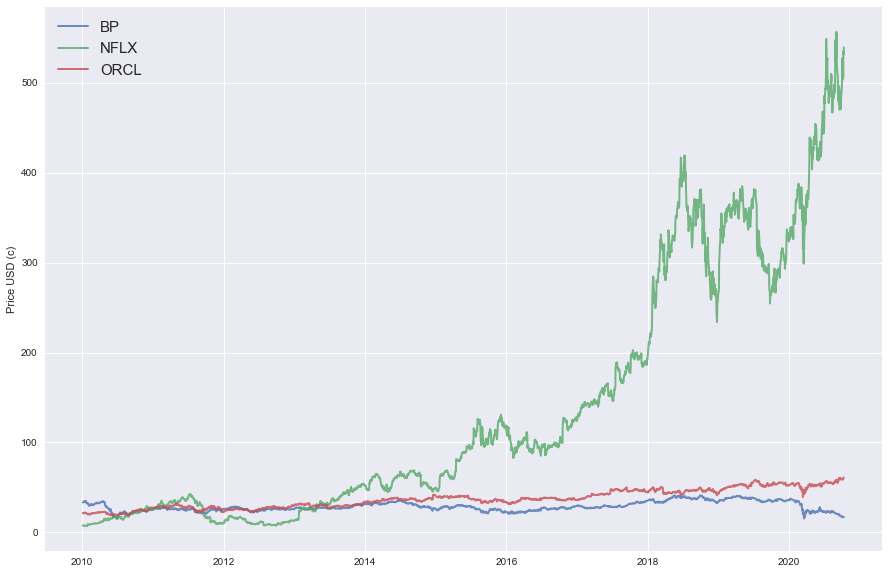

In [29]:
# get some example finance data from yahoo finance using yfinance package
import yfinance

stock_data = yfinance.download(tickers=['ORCL', 'NFLX', 'BP'],
                              start="2010-01-01")['Adj Close'] # oracle, netflix, BP, all priced in USD (even BP, quote from NYSE)

# plot the different stock price history
plt.figure(figsize=(15,10))

for stock in stock_data.columns:
    plt.plot(stock_data.index, stock_data.loc[:, stock], lw=2, alpha=0.8, label=stock)
plt.legend(fontsize=15)
plt.ylabel("Price USD (c)")

When analysing stock price data, it is often helpful to look at the dristribution of returns. In this case the data provided is daily price data, so we look at the daily return of prices.

In [40]:
daily_returns = stock_data.pct_change()
mean_returns = daily_returns.mean()
covariance_returns = daily_returns.cov()

Calculate the portfolio performance of a portfolio which is equally weighted for each of the three stocks, 
BP, Oracle, Netflix.

In [41]:
num_stocks = len(stock_data.columns)
weights = np.repeat(1/num_stocks, num_stocks)
annualised_portfolio_returns = np.sum(mean_returns * weights)*252
annualised_volatility = np.sqrt(np.dot(weights.T, np.dot(covariance_returns, weights))) * np.sqrt(252)

In [61]:
print(f"Individual stock returns (annualised) \n {mean_returns*252}")
print(f"\n Annualised portfolio returns: {annualised_portfolio_returns*100: 3f}%")


Individual stock returns (annualised) 
 BP     -0.014947
NFLX    0.529217
ORCL    0.129502
dtype: float64

 Annualised portfolio returns:  21.459033%


In [68]:
from typing import Tuple, List
# make a method out of the above
def calculate_portfolio_performance_metrics(
    price_df: pd.DataFrame,
    num_portfolios: int,
    risk_free_rate: float) -> Tuple[np.ndarray, List[float]]:
    """
    Calculation portfolio performance metrics: annual standard deviation (volatility), return
    and Sharpe ratio

    Args:
        num_portfolios: Number of different portfolios to try with random allocation to each stock
        risk_free_rate: Risk free rate of return from investing. 0.015 = 1.5%

    Returns:
        tuple: (std dev, ret, Sharpe) for each portfolio
        list: weight of each stock in portfolio
    """
    daily_returns = price_df.pct_change()
    mean_return_df = daily_returns.mean()
    covariance_returns = daily_returns.cov()
    
    portfolio_results = np.zeros((num_portfolios, 3))
    weights_lst = []
    for i in range(num_portfolios):
        weights = np.random.random(mean_return_df.shape[0])  # random numbers between 0 and 1
        weights /= np.sum(weights)
        weights_lst.append(weights)

        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(covariance_returns, weights))) * np.sqrt(252)
        portfolio_return = np.sum(mean_returns * weights)*252
        
        portfolio_results[i, 0] = portfolio_std
        portfolio_results[i, 1] = portfolio_return
        portfolio_results[i, 2] = (portfolio_return - risk_free_rate) / portfolio_std

    return portfolio_results, weights_lst

In [92]:
results, optimal_weights = calculate_portfolio_performance_metrics(
    price_df=stock_data,
    num_portfolios=1000,
    risk_free_rate=0.01)

resulting_portfolios = pd.DataFrame(data=results, columns = ['Volatility', 'Portfolio Return', 'Sharpe Ratio'])

In [87]:
print(f"{resulting_portfolios.shape[0]} results: \n {resulting_portfolios.head()}... \n")
print(f"{len(optimal_weights)} optimal weight allocations: {optimal_weights[:2]}... \n")


1000 results: 
     St dev.  Portfolio Return  Sharpe Ratio
0  0.331628          0.318581      0.930504
1  0.283400          0.268409      0.911817
2  0.234321          0.137452      0.543919
3  0.488930          0.502049      1.006380
4  0.285413          0.010376      0.001317... 

1000 optimal weight allocations: [array([0.25681562, 0.5658424 , 0.17734199]), array([0.21788134, 0.42625298, 0.35586569])]... 



The results in their vectorised form are not too meaningful, so to make sense of these portfolios, plot the 
annualised return and volatility for each portfolio, plotting the efficient frontier, and identify the most 
optimal portfolio for investment by the highest Sharpe Ratio (maximum units of return per unit risk), and
also return the portfolio with the lowest level of risk.

In [93]:
max_sharpe_loc = np.argmax(resulting_portfolios['Sharpe Ratio']) # 985

In [97]:
resulting_portfolios.sort_values("Sharpe Ratio", ascending=False)

,Volatility,Portfolio Return,Sharpe Ratio
985,0.392475,0.411522,1.023052
296,0.364662,0.383044,1.022986
265,0.352574,0.369822,1.020557
185,0.370680,0.387858,1.019366
317,0.350048,0.366590,1.018689
...,...,...,...
466,0.269407,0.016576,0.024408
633,0.272797,0.014771,0.017489
27,0.269821,0.009750,-0.000926
438,0.274890,0.009162,-0.003049


In [104]:
# get the locations of where the maximal Sharpe Ratio is
sharpe_max = resulting_portfolios.iloc[max_sharpe_loc, 2]
max_sharpe_loc_return = resulting_portfolios.iloc[max_sharpe_loc, 0] 
max_sharpe_loc_vol = resulting_portfolios.iloc[max_sharpe_loc, 1] 

In [117]:
# get the stats of return and std dev (volatility) of the portfolio
max_sharpe_allocation = pd.DataFrame(optimal_weights[max_sharpe_loc],
                                    index=stock_data.columns, 
                                    columns=['allocation'])
max_sharpe_allocation['allocation %'] = np.round(max_sharpe_allocation['allocation']*100, 2)

In [118]:
max_sharpe_allocation

,allocation,allocation %
BP,0.010161,1.02
NFLX,0.709226,70.92
ORCL,0.280613,28.06


Now look at the minimum volatility allocations

In [123]:
min_vol_loc = np.argmin(resulting_portfolios['Sharpe Ratio']) #19
min_vol = resulting_portfolios.iloc[min_vol_loc, 0]
min_vol_return = resulting_portfolios.iloc[min_vol_loc, 1]
min_vol_sharpe = resulting_portfolios.iloc[min_vol_loc, 2]
min_vol_allocation = pd.DataFrame(optimal_weights[min_vol_loc],
                                    index=stock_data.columns, 
                                    columns=['allocation'])
min_vol_allocation['allocation %'] = np.round(min_vol_allocation['allocation']*100, 2)


In [124]:
min_vol_allocation

,allocation,allocation %
BP,0.905386,90.54
NFLX,0.017153,1.72
ORCL,0.077460,7.75


In [150]:
perf_measures = pd.DataFrame(
    data=resulting_portfolios,
    columns=['Annualised Volatility %', 'Annualised Return %', 'Sharpe Ratio']
)
alloc = pd.DataFrame(optimal_weights * 100,
                  columns=[f"{i}%" for i in stock_data.columns])
summary = pd.concat([perf_measures, alloc], axis=1)
# summary.sort_values(by=['Sharpe Ratio'], ascending=False, inplace=True)

In [151]:
resulting_portfolios

,Volatility,Portfolio Return,Sharpe Ratio
Portfolio number,,,
0,0.280085,0.260669,0.894973
1,0.227607,0.134660,0.547699
2,0.267364,0.236652,0.847726
3,0.224224,0.117020,0.477293
4,0.335373,0.346694,1.003941
...,...,...,...
995,0.289151,0.290381,0.969669
996,0.263504,0.242412,0.882004
997,0.255057,0.229337,0.859950


In [152]:
alloc

,BP%,NFLX%,ORCL%
0,0.243914,0.416297,0.339789
1,0.391723,0.154466,0.453811
2,0.289929,0.372840,0.337230
3,0.337088,0.090592,0.572320
4,0.063796,0.566424,0.369780
...,...,...,...
99995,0.061910,0.424857,0.513233
99996,0.200211,0.354828,0.444960
99997,0.191175,0.318852,0.489973
99998,0.574572,0.095256,0.330172


Text(0.5, 1.0, 'Simulated Portfolio Optimisation using Efficient Frontier')

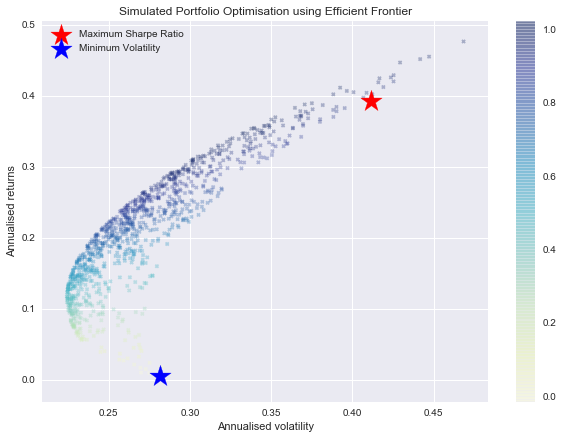

In [154]:
  # Plot the efficient frontier for the portfolios tested
plt.figure(figsize=(10, 7))
plt.scatter(x=results[:, 0],
            y=results[:, 1],
            c=results[:, 2],
            cmap='YlGnBu',
            marker="x",
            s=10,
            alpha=0.3)
plt.colorbar()
plt.scatter(x=max_sharpe_loc_vol, y=max_sharpe_loc_return, marker="*",
            color="r", s=500, label='Maximum Sharpe Ratio')
plt.scatter(x=min_vol, y=min_vol_return, marker="*",
            color="b", s=500, label='Minimum Volatility')
plt.xlabel("Annualised volatility")
plt.ylabel("Annualised returns")
plt.legend()
plt.title("Simulated Portfolio Optimisation using Efficient Frontier")

In [156]:
print(f"-" * 50 + "\n", "Maximum Sharpe Ratio Portfolio Allocation: \n \n",
          f"\t Sharpe Ratio: \t {round(sharpe_max, 4)} \n",
          f"\t Annualised Return: \t {round(max_sharpe_loc_return, 4)}",
          f" \n \t Annualised Volatility: \t {round(max_sharpe_loc_vol, 4)} \n \n",
          max_sharpe_allocation.T)
print(f"-" * 50 + "\n" "Minimum volatility Portfolio Allocation: \n",
          f"\t Sharpe Ratio: \t {round(min_vol_sharpe, 4)}, \n",
          f"\t Annualised Return: \t {round(min_vol_return, 4)}",
          f" \n \t Annualised Volatility: \t {round(min_vol, 4)} \n \n",
          min_vol_allocation.T)

--------------------------------------------------
 Maximum Sharpe Ratio Portfolio Allocation: 
 
 	 Sharpe Ratio: 	 1.0231 
 	 Annualised Return: 	 0.3925  
 	 Annualised Volatility: 	 0.4115 
 
                     BP       NFLX       ORCL
allocation    0.010161   0.709226   0.280613
allocation %  1.020000  70.920000  28.060000
--------------------------------------------------
Minimum volatility Portfolio Allocation: 
 	 Sharpe Ratio: 	 -0.0157, 
 	 Annualised Return: 	 0.0056  
 	 Annualised Volatility: 	 0.2815 
 
                      BP      NFLX     ORCL
allocation     0.905386  0.017153  0.07746
allocation %  90.540000  1.720000  7.75000
